## Surface Observation Data Screening
#### Karl Lapo, October/2015
### Test robustness of station data -- visual QC
1) Current daily data ('grobs.daily.nc')
    - no additional QC or screening
    - run through EOFs to check for consistency between stations
2) Qsi anomalies and EOF/PC analysis (removing annual cycle)
    - anomaly relative to all ground observations (shown, more interesting eof signal)
    - anomaly relative to individual group (very small signal)
3) Load hourly data
    - throw out days with bad night time QC
    - require 80% of day time obs to be present to make daily average

#### Questions
    - How much data do I lose?
    - How does it compare to the original data set?
    - Do EOF patterns change?
    
#### Test robustness of station data -- visual QC
    - Remove smj, station behaves radically differently than other stations
    - Encouragingly robust behavior across groups
    
#### Jan 2016
#### Refining QC for publication
Need to demonstrate how the screening using comparison to other sites works before sending the paper out to review.

    -Need to load and analyze the raw data (without any station removal, previously motivated by this script).
    -Look at the linearity of anomalies

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xray
import pandas as pd
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from datetime import datetime, timedelta
import pytz
import kray #### Custom functions for manipulating xray structures

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Solargeometry
import solargeo

# OS interaction
import sys
import os

In [2]:
#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

# General directories
dir_data = dir_pre+'SnowHydrology/proj/CloudClimatology/data'
dir_grobs = dir_pre+'/GroundObs'
dir_print = dir_pre+'SnowHydrology/proj/CloudClimatology/Graphics'
dir_bmap = dir_pre+'SnowHydrology/proj/CloudClimatology/data/basemap'

# Individual data directories
dir_cv_cimis_ucipm = dir_pre+'GroundObs/CA_CentralValley.UCDavis/RAW/CIMIS/UCDavis_IPM.Daily'
dir_cv_cimis = dir_pre+'GroundObs/CA_CentralValley.UCDavis/RAW/CIMIS/CIMIS.Hourly'
dir_sio_cdwr = dir_pre+'SnowHydrology/proj/CloudClimatology/data/GroundObs/YOS.SIO.Obs'

In [3]:
#### Flags
FLAG_EOF = 0 # Run EOF analysis (computationally expensive!)
flagOldData = 1 # Read data text files and format into xray Dataset (data w/ no processing)

In [4]:
#############################################################################################
## Functions
#############################################################################################

In [5]:
from scipy import interpolate as interp
from scipy.stats.stats import pearsonr
from scipy import stats

#### Function for creating anomalies
def anom(ds_in):
    def extrap1d(interpolator):
    ## Helper function for creating extrapolated values (linear)
    # http://stackoverflow.com/questions/2745329/...
    # ...how-to-make-scipy-interpolate-give-an-extrapolated-result-beyond-the-input-range
        from scipy import array
        xs = interpolator.x
        ys = interpolator.y

        def pointwise(x):
            if x < xs[0]:
                return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
            elif x > xs[-1]:
                return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
            else:
                return interpolator(x)

        def ufunclike(xs):
            return array(map(pointwise, array(xs)))

        return ufunclike

    # Time averaging -- monthly averaging
    # Monthly mean composite
    comp_mean = ds_in.groupby('time.month').mean(dim='time').mean(dim='station')

    ## Daily, mean anomaly -- interpolate monthly composite
    # Daily composite mean calculated from interpolation of monthly composite mean
    comp_mean_daily = xray.Dataset()
    # Julian day of month mid point for non-leap year. Force the function to be cyclic
    x_month = np.array([0,15.5, 45, 74.5, 105, 135.5, 166, 196.5, 227.5, 258, 288.5, 319, 349.5,365])

    # Daily anomaly for each group
    y = comp_mean.values
    y_cyclic = np.mean([y[0],y[-1]])
    y = np.insert(y,0,y_cyclic)
    y = np.append(y,y_cyclic)
    # Interpolation function of monthly composite
    daily_interp_f = interp.interp1d(x_month,y)
    # Linear extrapolation for beginning and end of year
    daily_interp_f = extrap1d(daily_interp_f)

    # Assign to structure
    comp_mean_daily = xray.Dataset()
    x_day = ds_in['time.dayofyear'].values
    comp_mean_daily['doy_mean'] = (('dayofyear'),daily_interp_f(x_day))
    
    comp_mean_daily = xray.Dataset({'doy_mean': (['time'],  daily_interp_f(x_day))},\
                                    coords={'time': (ds_in['time']),\
                                    'dayofyear': x_day})
    # Fill out coords
#     comp_mean_daily.coords['time'] = ('dayofyear',ds_in['time'])
#     comp_mean_daily = comp_mean_daily.swap_dims({'dayofyear':'time'})
    ds_anom = ds_in - comp_mean_daily
    return(ds_anom)

In [6]:
##### Iterative eof 
def naneof_BR2003(X):
    Xfunc = np.copy(X)
    if np.abs(np.nanmean(Xfunc)) > .001:
        # Remove nanmean of data
        dat_mean = np.nanmean(Xfunc)
        Xfunc[~np.isnan(Xfunc)] = Xfunc[~np.isnan(Xfunc)]-dat_mean
    else:
        dat_mean = 0
    ## Subset of data for validation, remove nans
    X0 = np.copy(Xfunc)
    idok_r,idok_c = np.nonzero(~np.isnan(Xfunc)) 
    id_val_r = idok_r[np.ceil(np.random.uniform(size=(np.floor(idok_r.shape[0]/50)))* \
                              idok_r.shape[0]).astype(int)-1] # validation subset (rows)
    id_val_c = idok_c[np.ceil(np.random.uniform(size=(np.floor(idok_c.shape[0]/50)))* \
                              idok_c.shape[0]).astype(int)-1] # validation subset (columns)
    
    X_val = Xfunc[id_val_r,id_val_c]
    mx_val = np.nansum(np.nansum(X_val**2))
    
    # remove validation subset from the data
    Xfunc[id_val_r,id_val_c] = np.nan;
    # Update index of non-nans
    idok_r,idok_c = np.nonzero(~np.isnan(Xfunc))
    # replace NaNs by zeros
    Xfunc[np.isnan(Xfunc)] = 0
    
    ## find out how many eigenfunctions to retain...
    Nit = 100
    tol = 1e-8
    err = np.empty(min(Xfunc.shape[1],20))*np.nan
    for Ne in np.arange(1,min(Xfunc.shape[1],20)):
        X1 = np.copy(Xfunc)
        for k in np.arange(2,Nit):
            # compute SVD (equivalent of economy method in matlab)
            U,D,V = np.linalg.svd(X1,full_matrices=False)
    
            # truncate and estimate "interpolated" D
            N = Ne
            Ut = U[:,0:N]
            Dt = D[0:N]
            Vt = V[0:N,:]
            Xa = np.dot(np.dot(Ut,np.diag(Dt)),Vt)
            Xa[idok_r,idok_c] = Xfunc[idok_r,idok_c] # restore real data
            X2 = np.copy(Xa)
    
            # termination criterium?
            dx=np.nansum((X2-X1)**2,axis=1)
            dx=dx[:,np.newaxis]
            mx=np.nansum(X2**2,axis=1)
            mx=mx[:,np.newaxis]
            dxex = np.linalg.lstsq(dx.T,mx.T)
            dxex = dxex[-1]
            if dxex < tol:
                print('Converged in '+str(k-1)+' iterations to the tolerance of '+str(tol))
                break
            X1 = np.copy(X2)
    
        # error?
        Xa = np.dot(np.dot(Ut,np.diag(Dt)),Vt)
        dx_val = np.nansum(np.nansum((Xa[id_val_r,id_val_c]-X_val)**2))
        err[Ne] = dx_val/mx_val
    
    ## Loop through again using the optimal number of eigenvalues only
    Nopt = np.flatnonzero(err == np.nanmin(err))
    
    X1 = np.copy(X0);
    # Subset of data for validation
    idok_r,idok_c = np.nonzero(~np.isnan(X1)) 
    X1[np.isnan(X1)] = 0
    for k in np.arange(2,Nit):
        # compute SVD (equivalent of economy method in matlab)
        U,D,V = np.linalg.svd(X1,full_matrices=False)#     N = Nopt;
        # truncate and estimate "interpolated" D
        N = Nopt
        Ut = U[:,0:N]
        Dt = D[0:N]
        Vt = V[0:N,:]
        Xa = np.dot(np.dot(Ut,np.diag(Dt)),Vt)
        Xa[idok_r,idok_c] = Xfunc[idok_r,idok_c] # restore real data
        X2 = np.copy(Xa)
        
        # termination criterium?
        dx=np.nansum((X2-X1)**2,axis=1)
        dx=dx[:,np.newaxis]
        mx=np.nansum(X2**2,axis=1)
        mx=mx[:,np.newaxis]
        dxex = np.linalg.lstsq(dx.T,mx.T)
        dxex = dxex[-1]
        if dxex < tol:
            print('Converged in '+str(k-1)+' iterations to the tolerance of '+str(tol))
            break
        X1 = np.copy(X2)
        
    # units in B
    B = np.dot(U,np.diag(D))  #the temporal modes
    amps = V # the spatial modes
    #the variance of the original temperature series
    orig_var = np.nanmean(X0**2) 
    #divide by the product of the original matrix size and by the variance
    variance = D**2/orig_var*100/(X0.shape[0]*X0.shape[1])
    
    return(B,amps,variance,dat_mean,Nopt,U,V,D)

In [4]:
##########################
## Part 1) Current Data ##
##########################
flagOldData = 0
if flagOldData:
    ## Load data (uncleaned)
    os.chdir(dir_data+'/GroundObs')
    
    ##### Process daily ground observations
    grobs = xray.open_dataset('CA.grobs_combined.daily.xray.nc')
    grobs = grobs.resample(freq='D', dim='time', how='mean')
    grobs.SWdwn.values[grobs.SWdwn.values == 0] = np.nan
    grobs = grobs.rename({'lon':'longitude','lat':'latitude'})
    grobs.longitude.values = -grobs.longitude.values

    ## Remove stations outside study domain
    # Bounding box - ragged domain
    LL_rag = [-120,34.5]
    LR_rag = [-115,34.5]
    UR_rag = [-118.5,41]
    UL_rag = [-123.5,41]

    # Station lat/lon
    stat_lat = grobs.latitude.values
    stat_lon = grobs.longitude.values

    # Ragged domain, CA study area
    line_west_m = (UL_rag[1]-LL_rag[1])/(UL_rag[0]-LL_rag[0])
    line_west_b = LL_rag[1]-line_west_m*LL_rag[0]
    line_east_m = (UR_rag[1]-LR_rag[1])/(UR_rag[0]-LR_rag[0])
    line_east_b = LR_rag[1]-line_east_m*LR_rag[0]
    ind = np.nonzero((stat_lon > (stat_lat -line_west_b)/line_west_m) & \
                    (stat_lon < (stat_lat-line_east_b)/line_east_m) & \
                    (stat_lat > LR_rag[1]) & (stat_lat < UL_rag[1]))
    # Reindex
    stat_to_keep = grobs.station[ind]
    grobs = grobs.reindex(station=stat_to_keep)

    ## Append station group information
    # Station data excel speadsheet
    stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                    index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
    # station data -> xray structure
    stdat = xray.Dataset(coords={'station': (['station'], stdat.index), \
                                 'Grouping': (['station'],  stdat.Grouping)})    
    # Merge into ground observation structure
    grobs = grobs.merge(stdat,join='inner')
    grobs = grobs.rename({'SWdwn':'grobs'})
    
    #### Nan months with less than 90% of days observing
    numdays_permonth = (~np.isnan(grobs.grobs)).resample(freq='M', dim='time', how='mean',label='right')
    numdays_permonth=numdays_permonth.reindex(time=grobs.time,method='bfill')
    grobs.grobs.values[numdays_permonth.values < .9] = np.nan
    
elif not flagOldData:
    ## Load data (cleaned)
    os.chdir(dir_data)
    grobs = xray.open_dataset('grobs.daily.nc')

## Slice only for the period with the majority of stations
# grobs = grobs.sel(time=slice('2007-10-01','2012-10-01'))
# qsi_anom = anom(grobs.grobs)

In [6]:
# print(grobs.sel(station='smj'))
# print(qsi_anom.sel(station='smj'))

In [9]:
## Iterative eofs
if FLAG_EOF:
    B,amps,variance,dat_mean,Nopt,U,V,D = naneof_BR2003(grobs.grobs.values)

In [10]:
if FLAG_EOF:
    ## Plot Results
    fig,axes = plt.subplots(1,6,figsize=(15,3))
    axes[0].plot(np.arange(1,11),variance[0:10],'-o')
    axes[0].set_title('eof variance explained')
    axes[0].set_ylabel('variance')
    axes[0].set_xlabel('eof #')

    ## Basemap of spatial patterns (EOFs) -- Entire study domain
    lon_stat = grobs.longitude.values
    lat_stat = grobs.latitude.values
    bmp,bmd = kgraph.build_basemap(lon_stat,lat_stat,dir_bmap,'CA.Domain.bmp.pickle')
    lat_labels = np.arange(34,42,2)
    lon_labels = np.arange(-116.,-124.,-2)

    ## Basemap of spatial patterns (EOFs) -- Mountain region
    # lat = np.array((36,38.1))
    # lon = np.array((-120.2,-117.5))
    # bmp,bmd = kgraph.build_basemap(lon,lat,dir_bmap,'CAMnt.Domain.bmp.pickle')
    # lat_labels = np.arange(36,39,.5)
    # lon_labels = np.arange(-120,-117,1)

    # Discrete colormap
    # cmap_delta = cmap_discretize(cm.RdBu_r,11)

    for n in np.arange(0,5):
        ax = axes[n+1]
        im = bmp.scatter(lon_stat,lat_stat,c=amps[n,:],s=75, linewidths=.25,latlon=True,\
                         ax=ax,cmap=cm.RdBu_r,vmin=-.5,vmax=.5)
        ax.set_title('eof coef '+str(n+1))

        ## Format
        if n == 0:
            bmp.drawparallels(lat_labels,labels=[1,0,0,0],ax=ax)
        else:
            bmp.drawparallels(lat_labels,ax=ax)
        bmp.drawmeridians(lon_labels,labels=[0,0,0,1],ax=ax) 

        # Colorbar
        if n == 2:
            cb = bmp.colorbar(im,"right", size="5%", pad='2%')
            cb.set_label('EOF (?)', fontsize=12)  

##### Result
    - Most of the data are described by the annual cycle (all dim and brighten at the same time
    - Other bizarre features that are barely relevant

In [11]:
if FLAG_EOF:
    ## Plot Results
    fig,axes = plt.subplots(1,6,figsize=(15,3))
    axes[0].plot(np.arange(1,11),variance[0:10],'-o')
    axes[0].set_title('eof variance explained')
    axes[0].set_ylabel('variance')
    axes[0].set_xlabel('eof #')

    ## Basemap of spatial patterns -- entire domain
    lon_stat = grobs.longitude.values
    lat_stat = grobs.latitude.values
    bmp,bmd = kgraph.build_basemap(lon_stat,lat_stat,dir_bmap,'CA.Domain.bmp.pickle')
    lat_labels = np.arange(34,42,2)
    lon_labels = np.arange(-116.,-124.,-2)

    ## Basemap of spatial patterns -- mountain stations
    # lat = np.array((36,38.1))
    # lon = np.array((-120.2,-117.5))
    # bmp,bmd = kgraph.build_basemap(lon,lat,dir_bmap,'CAMnt.Domain.bmp.pickle')
    # lat_labels = np.arange(36,39,.5)
    # lon_labels = np.arange(-120,-117,1)

    # Discrete colormap
    # cmap_delta = cmap_discretize(cm.RdBu_r,11)

    for n in np.arange(0,5):
        ax = axes[n+1]
        im = bmp.scatter(lon_stat,lat_stat,c=amps[n,:],s=75, linewidths=.25,latlon=True,\
                         ax=ax,cmap=cm.RdBu_r,vmin=-.5,vmax=.5)
        ax.set_title('eof coef '+str(n+1))

        ## Format
        if n == 0:
            bmp.drawparallels(lat_labels,labels=[1,0,0,0],ax=ax)
        else:
            bmp.drawparallels(lat_labels,ax=ax)
        bmp.drawmeridians(lon_labels,labels=[0,0,0,1],ax=ax) 

        # Colorbar
        if n == 2:
            cb = bmp.colorbar(im,"right", size="5%", pad='2%')
            cb.set_label('EOF (?)', fontsize=12)  

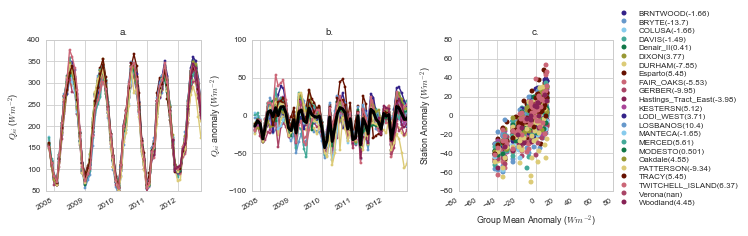

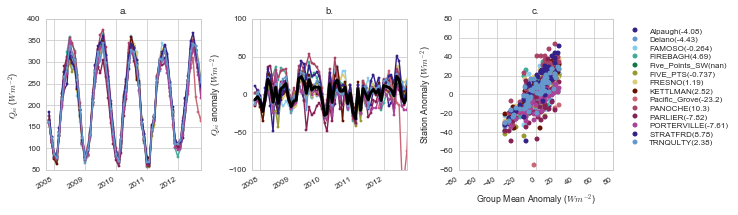

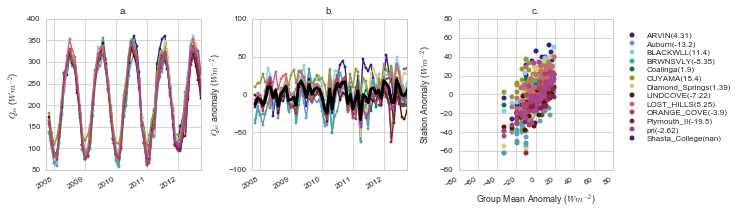

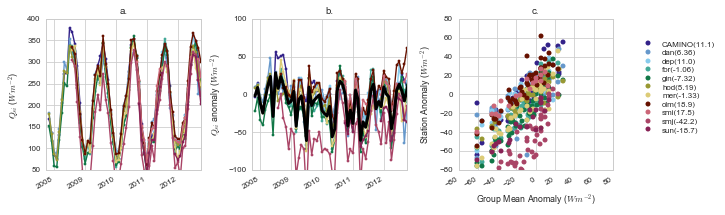

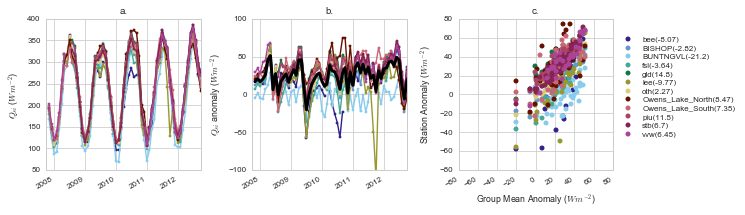

In [40]:
## Identifying individual stations that seem to be behaving differently
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
# Date limits
d1 = datetime(2007,10,1)
d2 = datetime(2012,10,1)

for n,gr in enumerate(grouping):
    # Information about each group
    numStations = qsi_anom.swap_dims({'station':'Grouping'}).loc[{'Grouping':'west of crest'}].Grouping.size
    stationsList = qsi_anom.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].station
    xTime = qsi_anom.resample(freq='M',dim='time',how='mean').time

    # Make figure
    # sns.set_palette(sns.husl_palette(numStations, l=.5))
    sns.set_palette(kgraph.SRON(12))
    fig = plt.figure(figsize=(12,3))
    gs = matplotlib.gridspec.GridSpec(1,4,\
                                  width_ratios=np.array((3,3,3,1)))
    gs.update(wspace=0.4)

    ## Qsi time series
    ax = plt.subplot(gs[0])
    for st in stationsList:
        ax.plot(xTime,grobs.grobs.sel(station=st).resample(freq='M',dim='time',how='mean'),marker='.',label=st)
    ax.set_xlim(d1,d2)
    ax.set_title('a.')
    ax.set_xlabel('')
    ax.set_ylim(50,400)
    ax.set_ylabel('$Q_{si}$ ($Wm^{-2}$)')

    ## Qsi anomaly
    ax = plt.subplot(gs[1])
    # Group mean
    ax.plot(xTime,qsi_anom.doy_mean.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
            mean(dim='Grouping').resample(freq='M',dim='time',how='mean'),\
            'k',lw=3,zorder=20)
    # Individual stations
    for st in stationsList:
        ax.plot(xTime,qsi_anom.doy_mean.sel(station=st).resample(freq='M',dim='time',how='mean'),\
                marker='.',label=st)
    # Format
    ax.set_xlim(d1,d2)
    ax.set_title('b.')
    ax.set_xlabel('')
    leg = ax.legend()
    leg.remove()
    ax.set_ylim(-100,100)
    ax.set_ylabel('$Q_{si}$ anomaly ($Wm^{-2}$)')

    ## Correlation of anomalies
    ax = plt.subplot(gs[2])
    # How do individual stations correlate with the group anomaly?
    groupAnom = qsi_anom.doy_mean.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
                mean(dim='Grouping').resample(freq='M',dim='time',how='mean')
    for st in stationsList:
        stationAnom = qsi_anom.doy_mean.sel(station=st).resample(freq='M',dim='time',how='mean')
        bias = np.nanmean(stationAnom-groupAnom)
        biasStringValue = '%s' % float('%.3g' % bias)
        ax.plot(groupAnom,stationAnom,\
                '.',label=st.values+"("+biasStringValue+")",markersize=10)

    # Format
    ax.set_xlim(-80,80)
    ax.set_ylim(-80,80)
    ax.set_title('c.')
    ax.set_xlabel('Group Mean Anomaly ($Wm^{-2}$)')
    ax.set_ylabel('Station Anomaly ($Wm^{-2}$)')
    handles, labels = ax.get_legend_handles_labels()

    ax = plt.subplot(gs[-1])
    ax.axis('off')
    ax.legend(handles, labels,loc='center',ncol=1,\
                        labelspacing=.25,markerscale=1,numpoints=1,\
                        bbox_to_anchor=(0, .3, .5, .5))

    fig.autofmt_xdate()

    ## print
    os.chdir(dir_print)
    fig.savefig('SurfObsUncertainty.'+gr+'.png')
    fig.savefig('SurfObsUncertainty.'+gr+'.pdf')


##### Results:
- smj station is out to lunch compared to typical spread within groups
- Some stations occasionally behave very differently than the group, but only for limited periods

north cv mean std in Qsi: 18 Wm-2
south cv mean std in Qsi: 18 Wm-2
foothills mean std in Qsi: 24 Wm-2
west of crest mean std in Qsi: 32 Wm-2
east of crest mean std in Qsi: 27 Wm-2


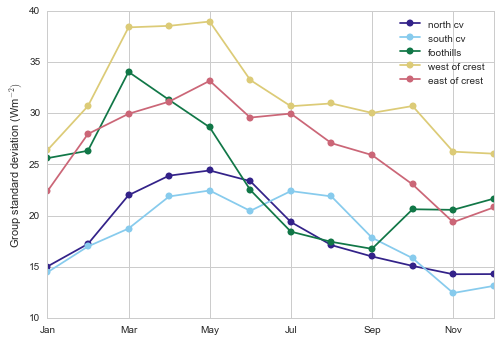

In [15]:
## Mean spread in Qsi across groups
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
colsche = kgraph.SRON(5)
fig, ax = plt.subplots(1,1)

for n,gr in enumerate(grouping):
    print(gr+' mean std in Qsi: '+\
            str(int(grobs.grobs.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
            std(dim='Grouping').mean(dim='time').values.round()))+\
            ' Wm-2')

    ax.plot(grobs.grobs.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
        std(dim='Grouping').groupby('time.month').mean(dim='time'),'-o',label=gr,color=colsche[n])
    ax.set_xticklabels(month_label[::2])
    plt.legend()
ax.set_xlim(0,11)
ax.set_ylabel('Group standard deviation (Wm$^{-2})$')

os.chdir(dir_print)
fig.savefig('SurfObsUncertainty.Season.png')
fig.savefig('SurfObsUncertainty.Season.pdf')

##### Results:
- Typical uncertainty within groups is 18-27 Wm-2, supporting my (slightly optimistic) statement that the observational uncertainty is 20Wm-2 on longer timescales.
- Ignoring west of crest due to the influence of 'smj' station
- From this I am going to adjust the uncertainty to $<abs(20Wm^{-2})$ for valley stations and $<abs(30Wm^{-2})$ for mountain stations
- Uncertainty has seasonality (peaking in the spring, shrinking into the summer), compare this to the seasonal bias
- Uncertainty shrinks using a longer period, 2004-2012, instead of 2007-2012. Most notable in the mountain stations (which makes sense, we add more stations in the latter part of the study period. Estimate of uncertainty may be too conservative.

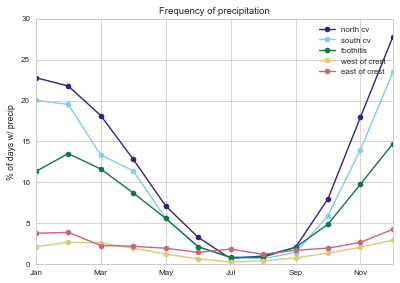

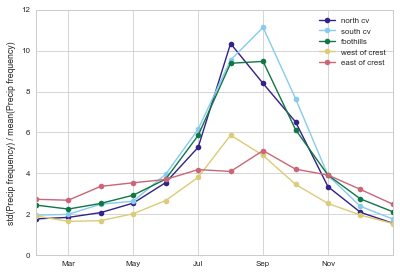

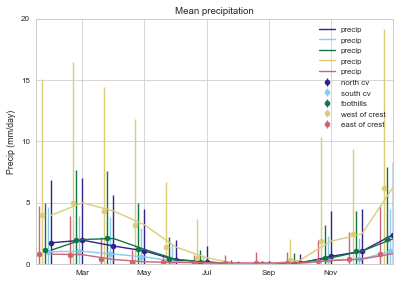

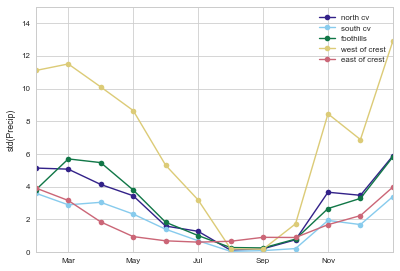

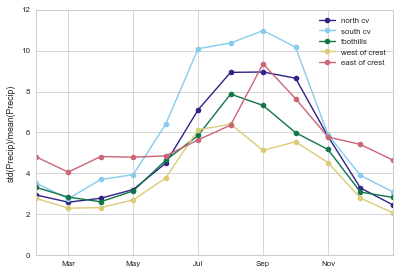

In [30]:
## Load precip data
os.chdir(dir_data)
grobsPrecip = xray.open_dataset('grobs.daily.nc')

###############################
## Precipitation climatology ##
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
colsche = kgraph.SRON(5)

## Mean occurrence
fig, ax = plt.subplots(1,1)
for n,gr in enumerate(grouping):
    ax.plot( (grobsPrecip.precip > 0).swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
        groupby('time.month').mean(dim='time').mean(dim='Grouping')*100,'-o',label=gr,color=colsche[n])
    ax.set_xticklabels(month_label[::2])
    plt.legend()
ax.set_xlim(0,11)
ax.set_title('Frequency of precipitation')
ax.set_ylabel('% of days w/ precip')

## Monthly std precip frequency
fig, ax = plt.subplots(1,1)
for n,gr in enumerate(grouping):
    X = np.arange(1, 13)
    Y = (grobsPrecip.precip > 0).swap_dims({'station':'Grouping'}).\
            loc[{'Grouping':gr}].\
            groupby('time.month').\
            mean(dim='time').\
            mean(dim='Grouping').values*100
    Yerr = (grobsPrecip.precip > 0).swap_dims({'station':'Grouping'}).\
            loc[{'Grouping':gr}].\
            groupby('time.month').\
            std(dim='time').\
            mean(dim='Grouping').values*100
    ax.plot(X, Yerr/Y, 'o-', color=colsche[n], label=gr)

ax.set_xticklabels(month_label[::2])
# ax.set_ylim(0, 15)
plt.legend()
ax.set_xlim(1,12)
ax.set_ylabel('std(Precip frequency) / mean(Precip frequency)')

## Mean monthly precip
fig, ax = plt.subplots(1,1)
for n,gr in enumerate(grouping):
    X = np.arange(1, 13)
    Y = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
            loc[{'Grouping': gr}].\
            groupby('time.month').\
            mean(dim='time').\
            mean(dim='Grouping')
    Yerr = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
            loc[{'Grouping': gr}].\
            groupby('time.month').\
            std(dim='time').\
            mean(dim='Grouping')
    ax.plot(X, Y, '-', color=colsche[n])
    ax.errorbar(X-.1*n, Y, yerr=Yerr, color=colsche[n], label=gr, fmt='o')

ax.set_xticklabels(month_label[::2])
ax.set_ylim(0, 20)
plt.legend()
ax.set_xlim(0.5,12)
ax.set_title('Mean precipitation')
ax.set_ylabel('Precip (mm/day)')

## Mean std precip
fig, ax = plt.subplots(1,1)
for n,gr in enumerate(grouping):
    X = np.arange(1, 13)
    Y = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
            loc[{'Grouping': gr}].\
            groupby('time.month').\
            mean(dim='time').\
            mean(dim='Grouping').values
    Yerr = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
            loc[{'Grouping': gr}].\
            groupby('time.month').\
            std(dim='time').\
            mean(dim='Grouping').values
    ax.plot(X, Yerr, 'o-', color=colsche[n], label=gr)

ax.set_xticklabels(month_label[::2])
ax.set_ylim(0, 15)
plt.legend()
ax.set_xlim(1,12)
ax.set_ylabel('std(Precip)')

## Mean normalized std precip
fig, ax = plt.subplots(1,1)
for n,gr in enumerate(grouping):
    X = np.arange(1, 13)
    Y = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
            loc[{'Grouping': gr}].\
            groupby('time.month').\
            mean(dim='time').\
            mean(dim='Grouping').values
    Yerr = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
            loc[{'Grouping': gr}].\
            groupby('time.month').\
            std(dim='time').\
            mean(dim='Grouping').values
    ax.plot(X, Yerr/Y, 'o-', color=colsche[n], label=gr)

ax.set_xticklabels(month_label[::2])
ax.set_ylim(0, 12)
ax.legend()
ax.set_xlim(1,12)
ax.set_ylabel('std(Precip)/mean(Precip)')

#### Precipitation Seasonality and Surface Observation Uncertainty
The seasonality of surface observation uncertainty is unrelated to the seasonality of precipitation occurence. There may be a _slight_ relationship between uncertainty and precipitation magnitude, but I'm not even close to convinced.

The bottom plot shows how uncertainty in $Q_{si}$(y-axis) is related to the mean precipitation/std precipitation (x-axis). Again, a _slight_ relationship, group by group, but nothing that I would publish. There may be other metrics that are better to use here. 

In [7]:
tau = xray.open_dataset('tau.daily.nc')

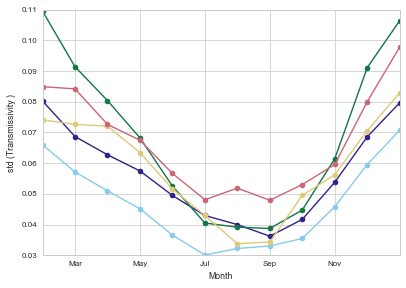

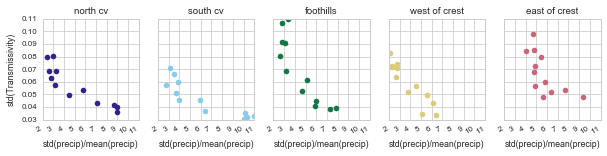

In [8]:
## Mean std precip
fig, ax = plt.subplots(1,1)
for n,gr in enumerate(grouping):
    Y = tau.tau.swap_dims({'station':'Grouping'}).\
            loc[{'Grouping':gr}].\
            std(dim='Grouping').\
            groupby('time.month').\
            mean(dim='time')
    ax.plot(np.arange(1,13), Y, 'o-', color=colsche[n])

ax.set_xticklabels(month_label[::2])
ax.set_xlim(1,12)
ax.set_ylabel('std (Transmissivity )')
ax.set_xlabel('Month')

##
fig, axes = plt.subplots(1,5, sharex=True, sharey=True, figsize=(10, 2))
axes = axes.flatten()
for n, gr in enumerate(grouping):
    ax = axes[n]
    Xmean = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
                loc[{'Grouping': gr}].\
                groupby('time.month').\
                mean(dim='time').\
                mean(dim='Grouping')
    Xstd = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
                loc[{'Grouping': gr}].\
                groupby('time.month').\
                std(dim='time').\
                mean(dim='Grouping')
    ax.plot(Xstd/Xmean,
             tau.tau.swap_dims({'station':'Grouping'}).\
                    loc[{'Grouping':gr}].\
                    std(dim='Grouping').\
                    groupby('time.month').\
                    mean(dim='time'),
            'o', color=colsche[n])
    ax.set_title(gr)
    if n == 0:
        ax.set_ylabel('std(Transmissivity)')
    ax.set_xlabel('std(precip)/mean(precip)')
fig.autofmt_xdate()

The monthly composited standard deviation in transmissivity (y-axis) is almost entirely explained by the monthly-composited normalized variability in precipitation (x-axis).

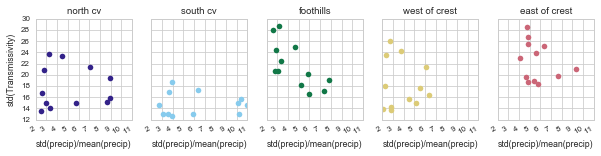

In [56]:
fig, axes = plt.subplots(1,5, sharex=True, sharey=True, figsize=(10, 2))
axes = axes.flatten()
for n, gr in enumerate(grouping):
    ax = axes[n]
    Xmean = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
                loc[{'Grouping': gr}].\
                groupby('time.month').\
                mean(dim='time').\
                mean(dim='Grouping')
    Xstd = grobsPrecip.precip.swap_dims({'station': 'Grouping'}).\
                loc[{'Grouping': gr}].\
                groupby('time.month').\
                std(dim='time').\
                mean(dim='Grouping')
    ax.plot(Xstd/Xmean,
             grobs.grobs.swap_dims({'station':'Grouping'}).\
                    loc[{'Grouping':gr}].\
                    std(dim='Grouping').\
                    groupby('time.month').\
                    mean(dim='time'),
            'o', color=colsche[n])
    ax.set_title(gr)
    if n == 0:
        ax.set_ylabel('std(Transmissivity)')
    ax.set_xlabel('std(precip)/mean(precip)')
fig.autofmt_xdate()